In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import datetime
import scipy
import os
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import glob

sns.set()

mpl.rc('font', family='serif', serif='cmr10')
mpl.rc('axes.formatter', use_mathtext=True)

# Preprocess

In [154]:
df = pd.read_csv('data/last_iter.csv', names=[
    "w", "c1", "c2", "benchmark", "rep_num", "iter_num", "gbest_fit", "gdiversity", "perc_oob"
])

# There's an issue with '1.0e100' not being intepreted correctly. Coerce these "strings" into numerics
df['perc_oob'] = df['perc_oob'].apply(pd.to_numeric, errors='coerce')
# Certain benchmark functions failed. Remove them:
df = df[~df['benchmark'].isin([
    "Deb 3 Function",               # Results in many NaNs
    "Generalized Price 2 Function", # Results in many inf or -inf
    "Generalized Paviani Function", # Results far too close to -inf
    "Mishra 1 Function",            # All values are the same
])]

/var/folders/y1/md9_k_td4rz1f0pq26d24crh0000gn/T/ipykernel_23736/118829346.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/last_iter.csv', names=[


## Pre-processing

1. Standardise the gbest_fit values to be zero-minimum and minimisation problems
1. Convert the 30 runs to a mean+- std dev


### Make sure the minimum is 0 and the range is 1 for all benchmarks

In [155]:
# Calculate the minimum per benchmark
minima = df.groupby('benchmark')['gbest_fit'].min()
# Calculate the range per benchmark
ranges = df.groupby('benchmark')['gbest_fit'].max() - minima

# Modify every fitness value to be between 0 and 1
df['gbest_fit'] = df.apply(
    lambda row: (row['gbest_fit'] - minima[row['benchmark']]) / ranges[row['benchmark']],
    axis=1
)
df['prob'] = df.apply(
    lambda row: 1 - ((row['gbest_fit'] - minima[row['benchmark']]) / ranges[row['benchmark']]),
    axis=1
)

gb = df.groupby('benchmark')['prob'].sum()
df['prob'] = df.apply(
    lambda row: row['prob'] / gb[row['benchmark']],
    axis=1
)
# assert (df.groupby('benchmark').prob.sum() == 1).all(), df.groupby('benchmark').prob.sum() 


### Create the column $c$ ( where $c=c_1+c_2$)

In [156]:
df['c'] = df['c1'] + df['c2']

### Collect the mean & std deviation of the fitness values

In [157]:
stats = (
    df.groupby(['benchmark', 'w', 'c'])['gbest_fit']
        .agg(['mean', 'std'])
        .reset_index()
        .sort_values('benchmark')
)

### Round the values to 4dp

This just prevents floating point issues like 1.0e-999 not being considered equal to 0

In [158]:
stats = np.round(
    stats,
    4
)

## Plot the heatmaps of every benchmark

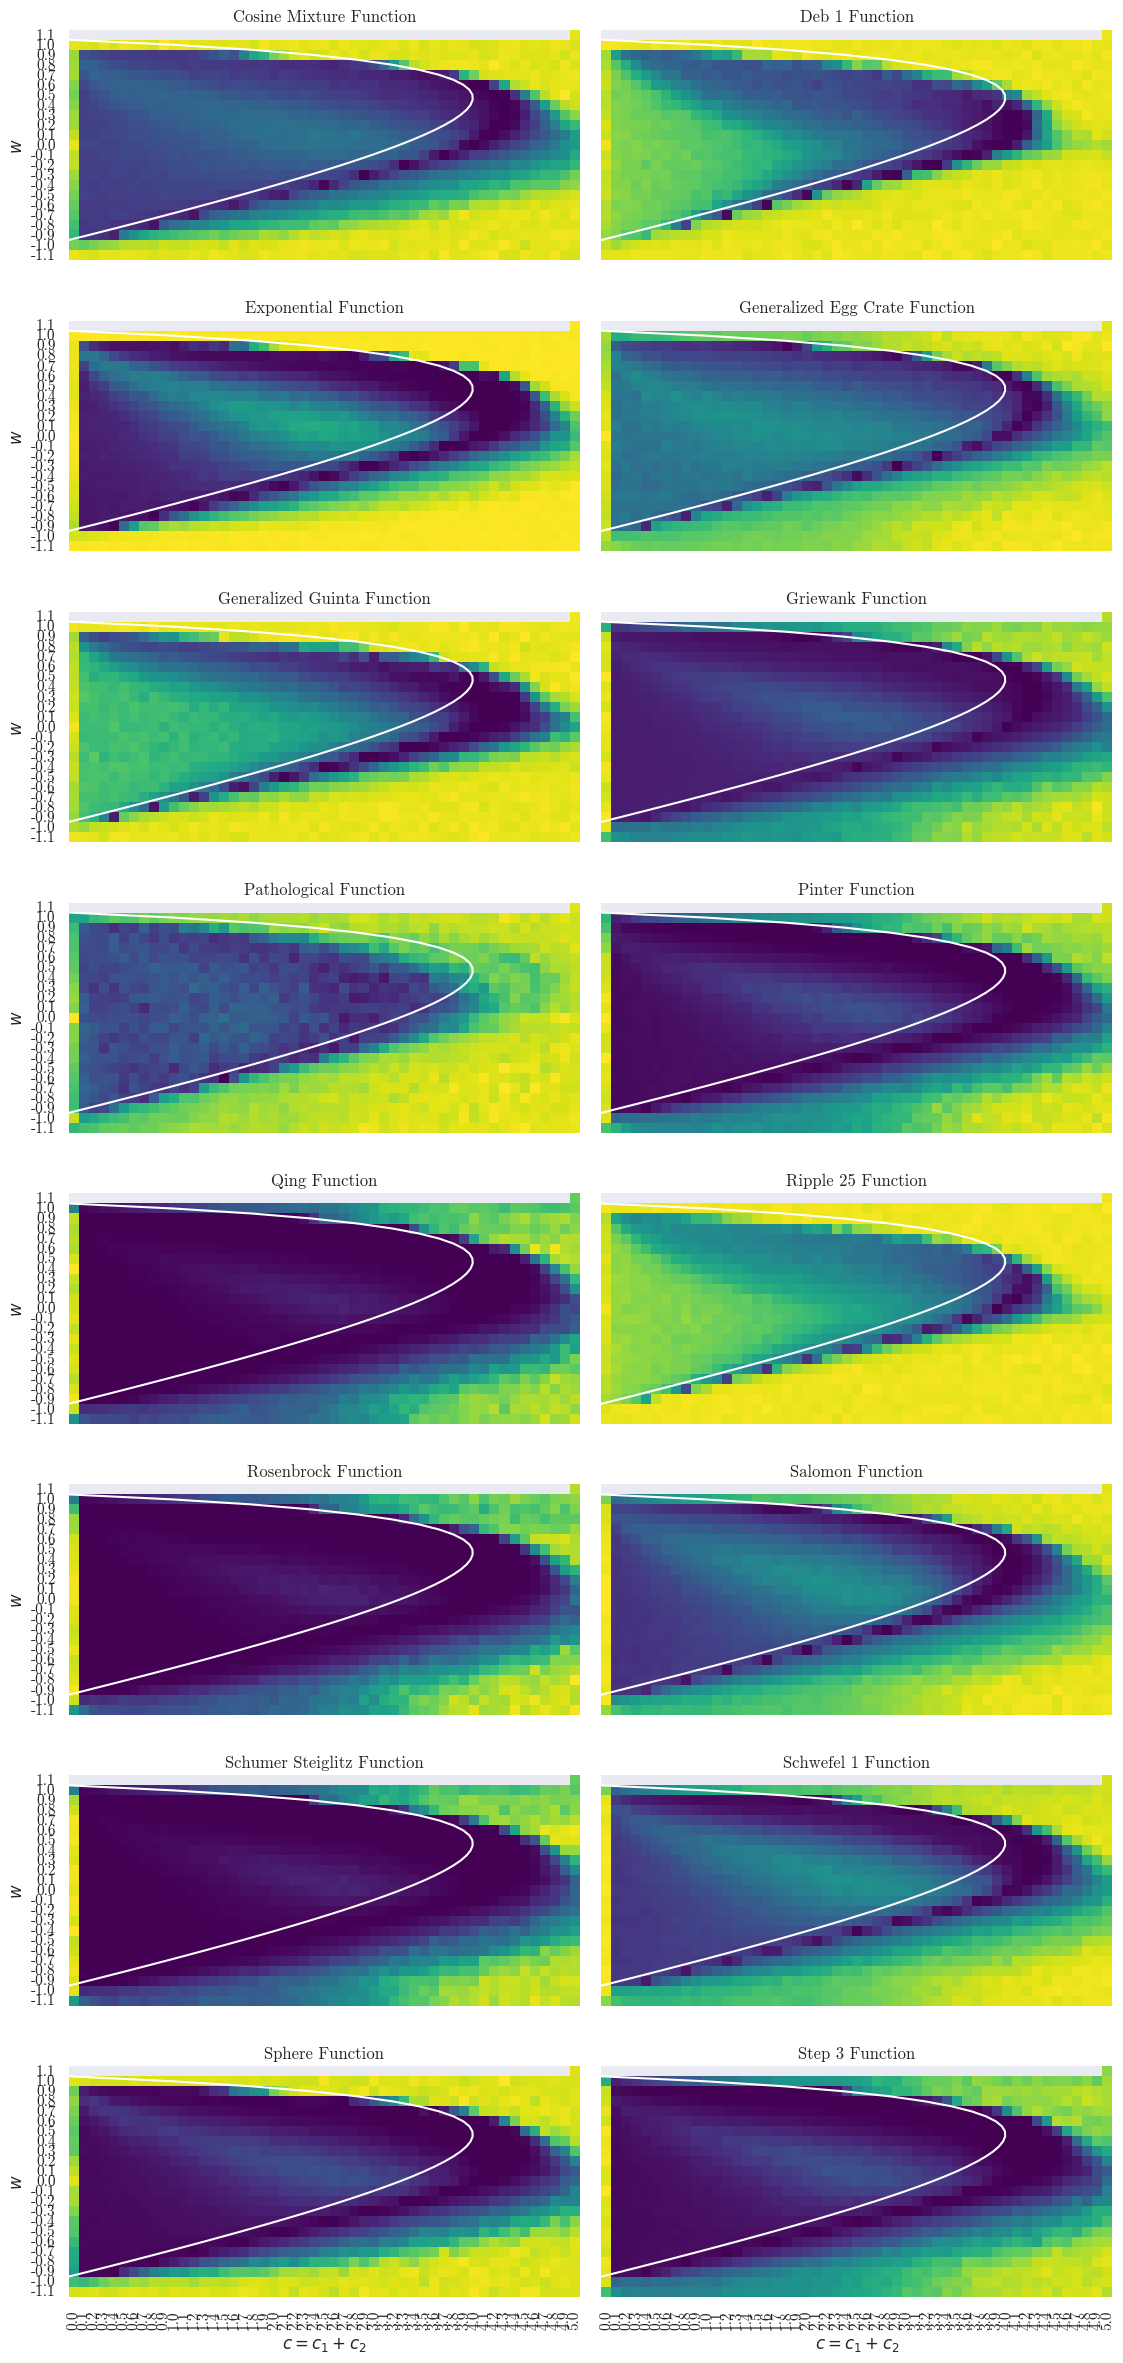

In [159]:
def make_heatmap_grid(stats, fname, title=None, ncols=3):
    w = np.arange(-1.1, 1.1, 0.05)
    c = (24 * (1 - w*w)) / (7 - 5 * (-w))
    x_offset = 0
    x_factor = 10
    y_offset = 11
    y_factor = 10
#     col_wrap = int(min(ncols, np.floor(np.sqrt(len(stats.benchmark.unique())))))
    col_wrap = 2

    def draw_heatmap(*args, **kwargs):
        data = kwargs.pop('data')
        d = data.pivot(columns=args[0], index=args[1], values=args[2])
        d = d.reindex(index=sorted(d.index)[::-1])
        d = d.reindex(columns=sorted(d.columns))
        ax = sns.heatmap(d, **kwargs)
        ax.plot(
            (c  * x_factor) + x_offset, 
            (w  * y_factor) + y_offset, 
            c='white'
        )
    stats['benchmark'] = stats['benchmark'].str.replace('Function ', '')
    g = sns.FacetGrid(stats,
                      col='benchmark', 
                      col_wrap=col_wrap,
                      height=3,
                      aspect=1.9
                     )

    g.map_dataframe(draw_heatmap, 'c', 'w', 'mean',
                    cmap="viridis",
                    yticklabels=True, 
                    xticklabels=True,
                    square=True,
                    cbar=False,
    )

    g.set_titles(
        col_template="{col_name}", 
    )
    g.set_axis_labels("$c=c_1+c_2$", "$w$")
    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(fname)

make_heatmap_grid(stats.copy(), '../report/imgs/heatmaps.pdf', ncols=3)

In [160]:
benchmarks = {
    'large scale multimodal': [
        "Ripple 25 Function",
        "Deb 1 Function",
        "Generalized Guinta Function",
        "Generalized Egg Crate Function",
    ],
    'small scale multimodal': [
        'Griewank Function',
        'Salomon Function',
    ],
    'unimodal': [
        "Qing Function",
        "Rosenbrock Function",
        "Schumer Steiglitz Function",
        "Pinter Function",
        "Sphere Function",
        "Step 3 Function",
        "Cosine Mixture Function",
        "Schwefel 1 Function",
        "Exponential Function",
    ],
    'other': [
        'Pathological Function',
    ]
}

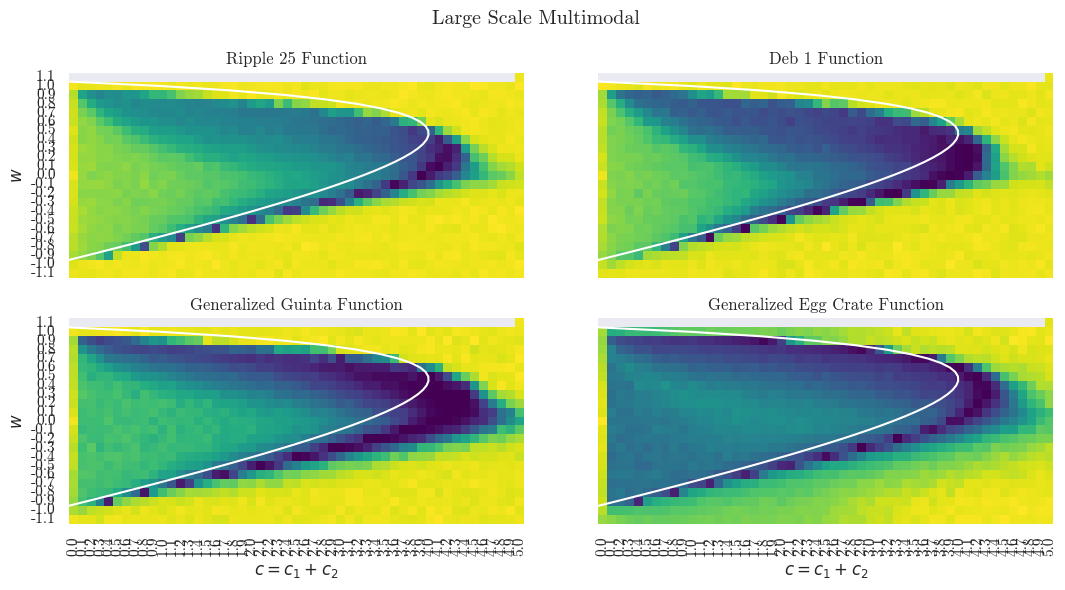

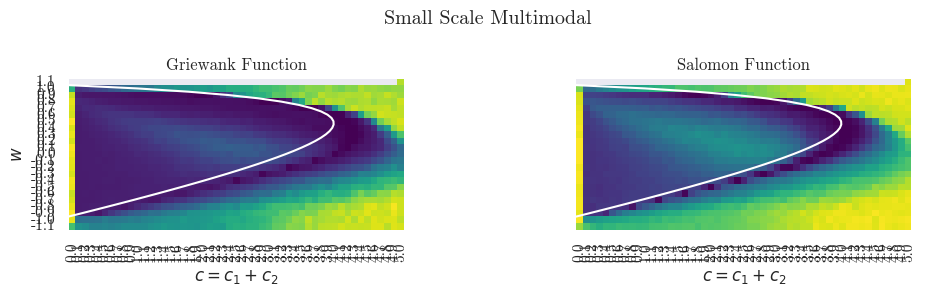

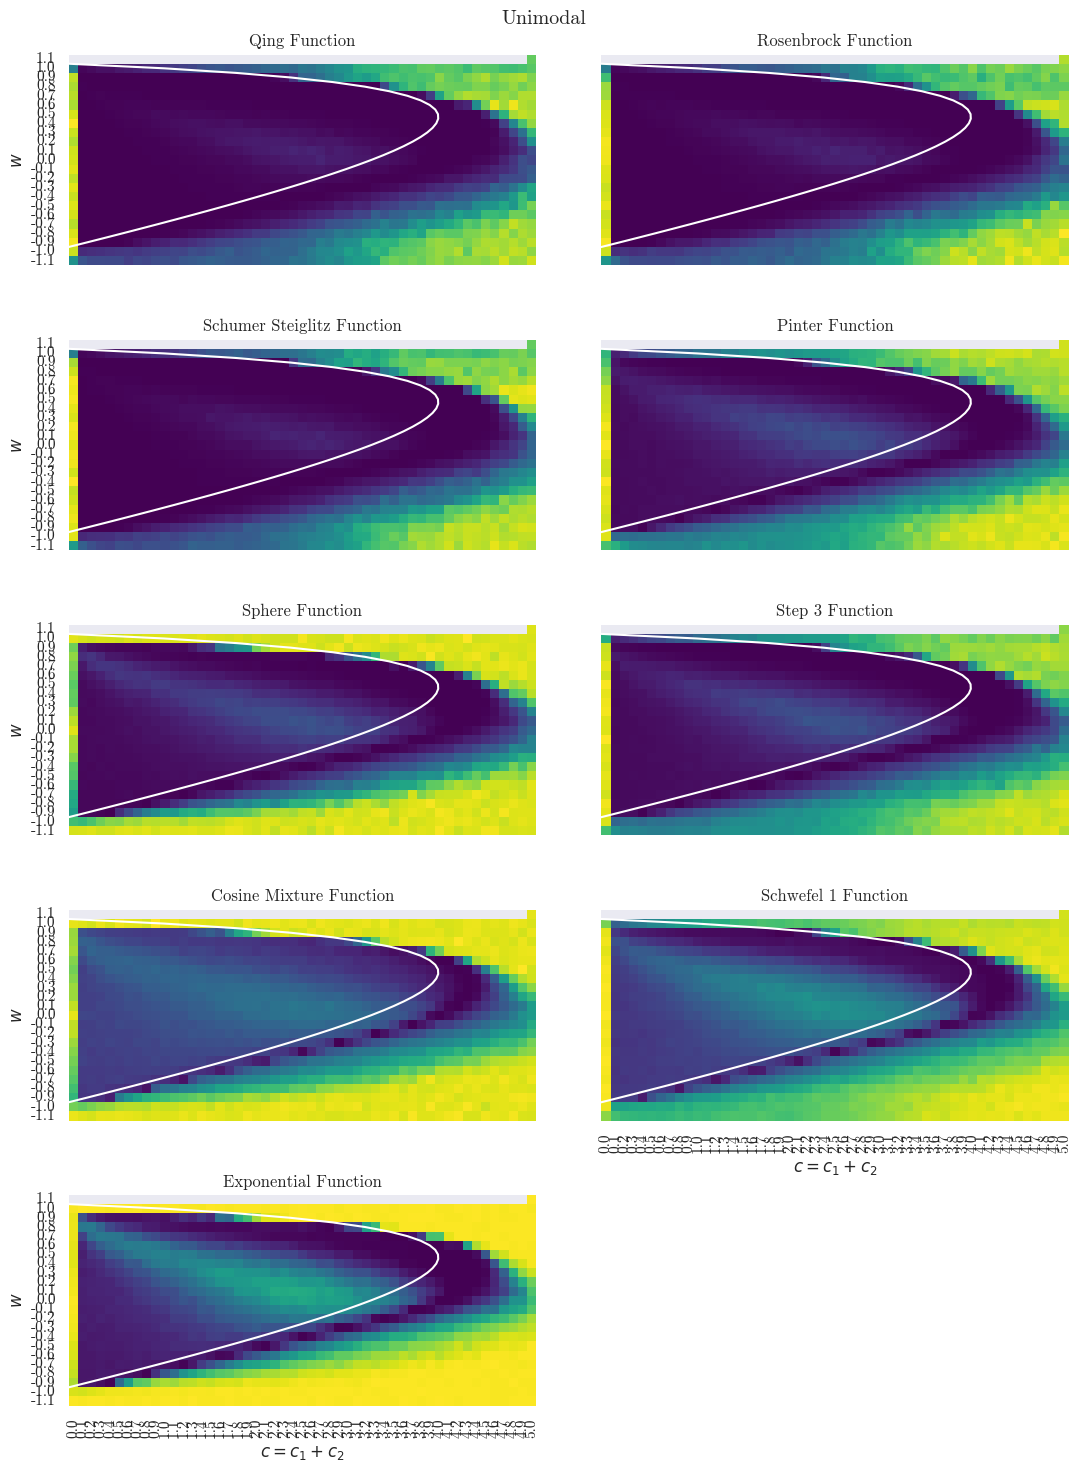

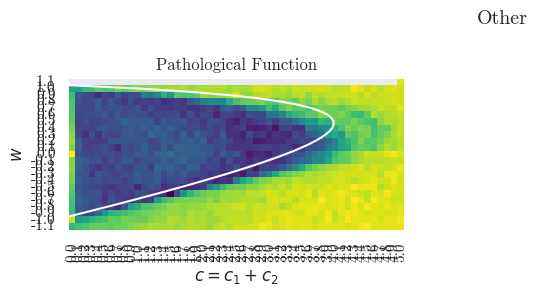

In [161]:
for kind, ls in benchmarks.items():
    # Sort the values according to how they appear in `benchmarks`
    data = stats[stats['benchmark'].isin(ls)].sort_values(
        'benchmark', 
        key=lambda col: col.apply(
            lambda x: {item: idx for idx, item in enumerate(ls)}.get(x, np.inf)
        )
    ).copy()
    make_heatmap_grid(
        data,
        f'../report/imgs/heatmaps_{kind.replace(" ", "_")}.pdf',
        title=kind.title(),
        ncols=2
    )

# Plot distributions of each evaluation benchmark

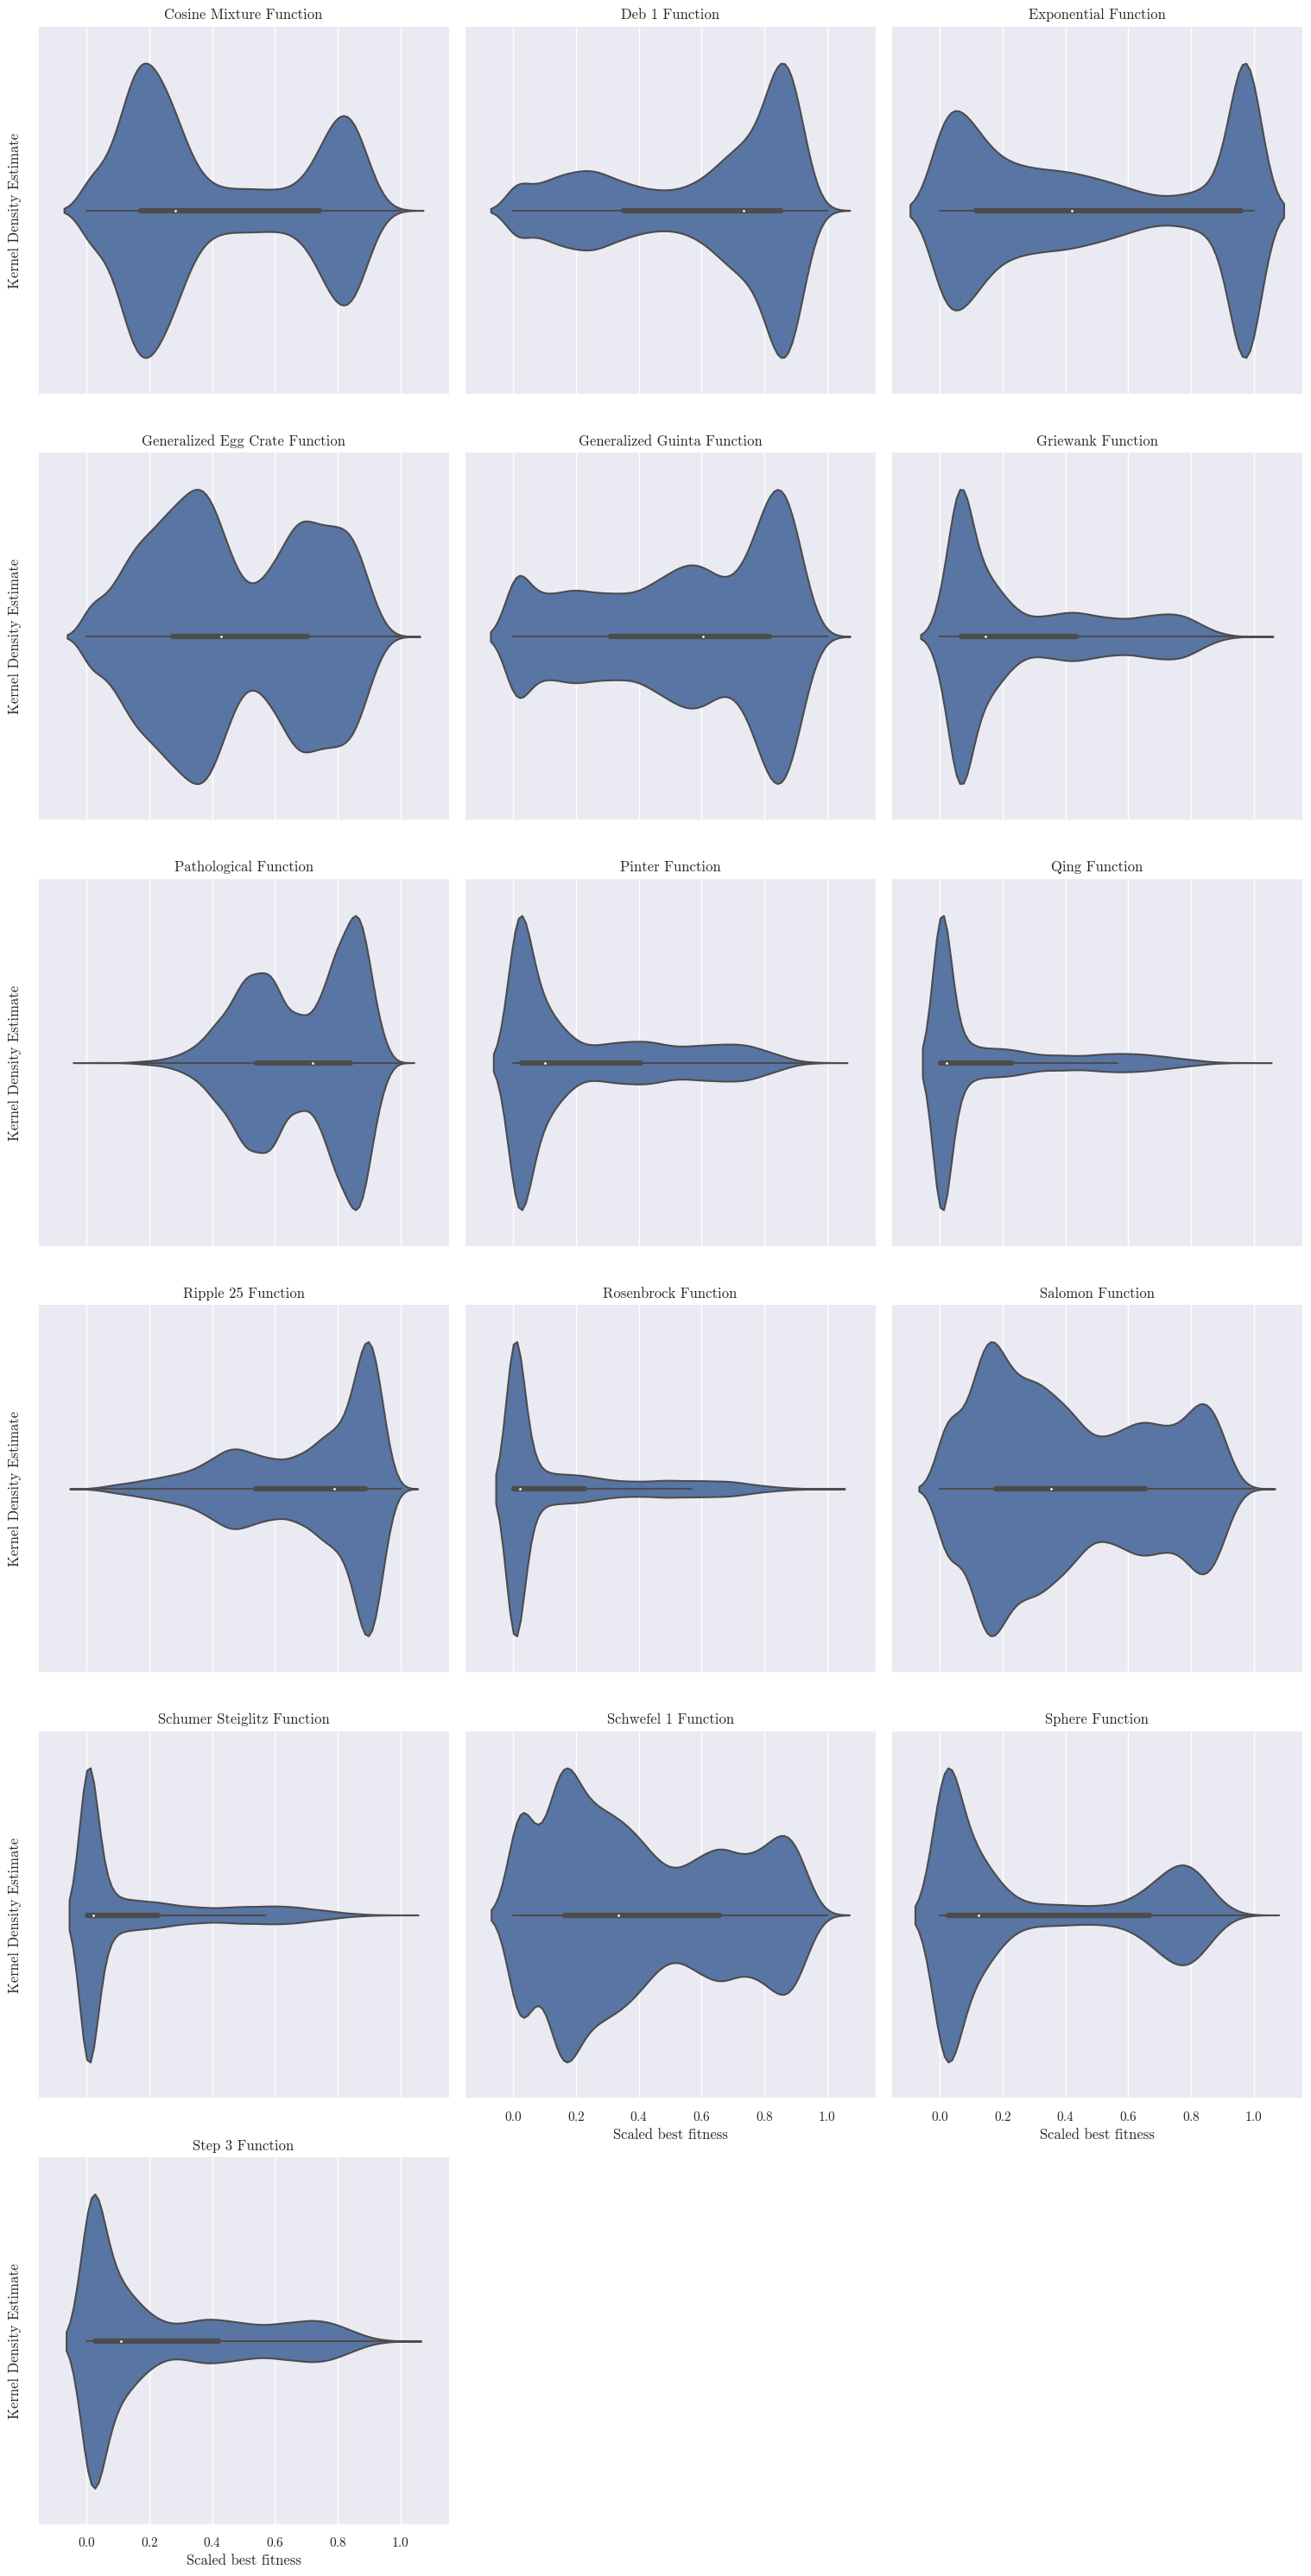

In [52]:
g = sns.catplot(
    data=df.sort_values('benchmark'),
    x='gbest_fit',
    col='benchmark',
    col_wrap=3,
    kind='violin'
)
g.set_axis_labels("Scaled best fitness", "Kernel Density Estimate")
g.set_titles("{col_name}")
means = df.groupby('benchmark')['gbest_fit'].mean()
plt.savefig('../report/imgs/kde_plot.pdf', bbox_inches='tight')

# Plot example plots in 2D

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 

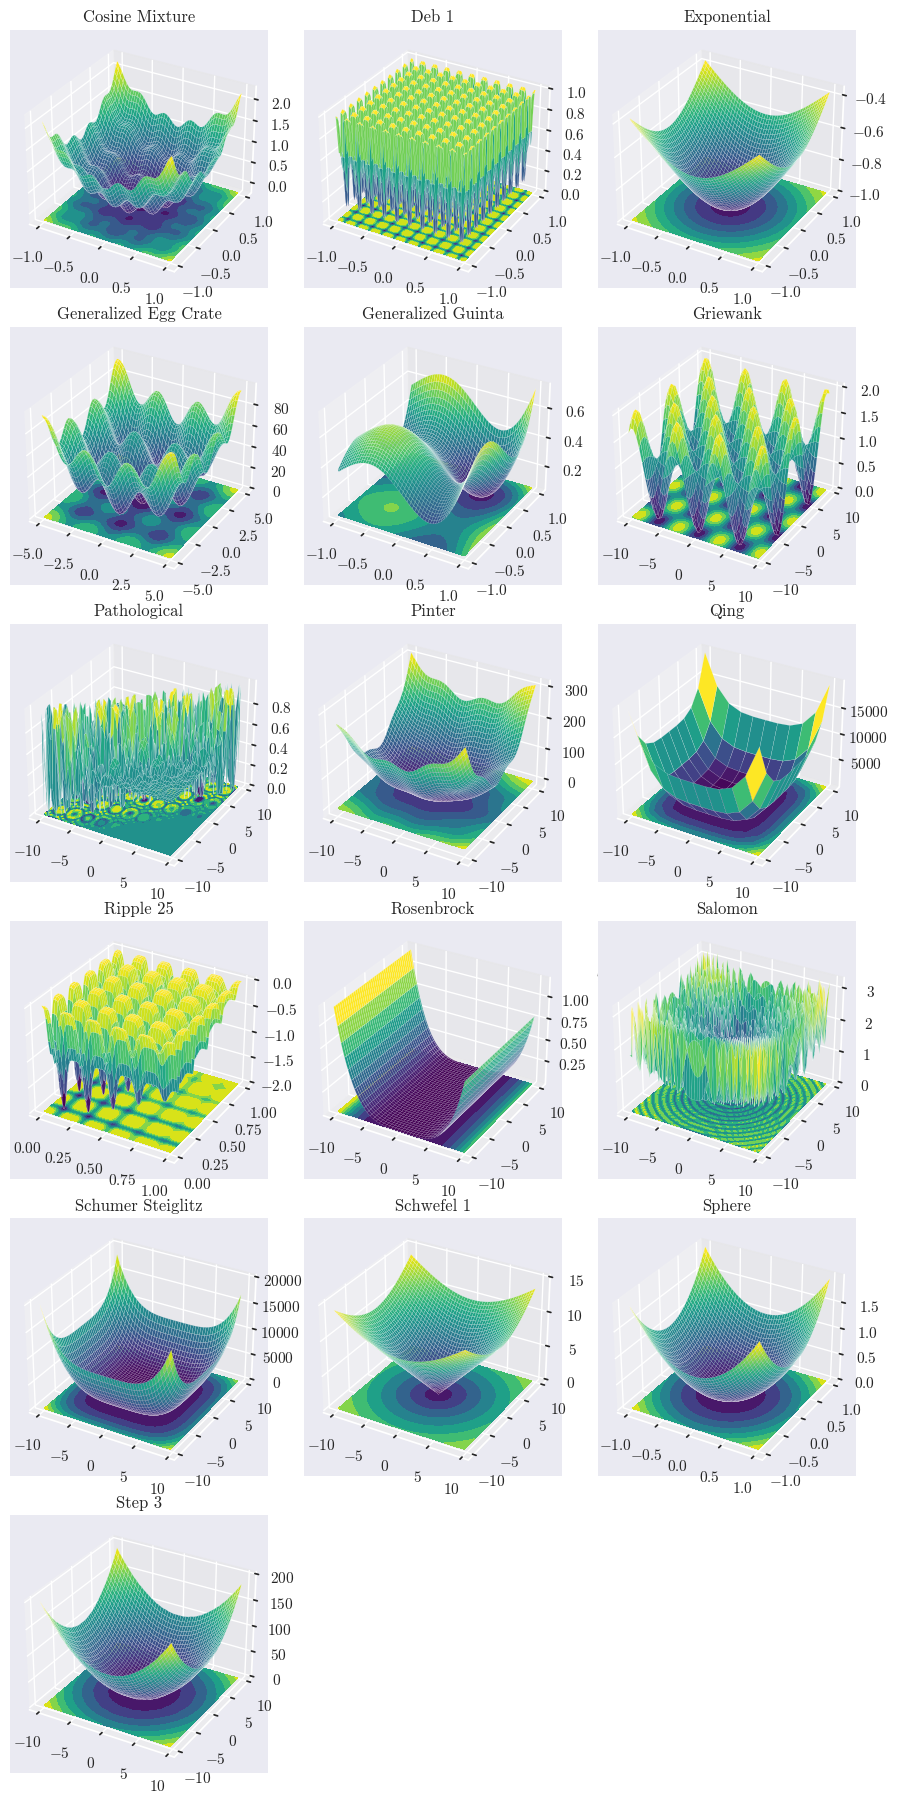

In [12]:
rng = [
    [-10, 10],
    [-10, 10],
]
nrows, ncols = (6, 3)
fig = plt.figure(figsize=(3*ncols, 3*nrows))
files = sorted(glob.glob('data/bm_values/*.csv'))
idx = 0
for i, file in enumerate(files):
    idx += 1
    df = pd.read_csv(file)
    df = df[df.x.between(*rng[0]) & df.y.between(*rng[1])]
    ax = fig.add_subplot(
        nrows,
        ncols,
        idx,
        projection='3d',
    )

    x = df['x'].values.reshape((len(df['x'].unique()), -1))
    y = df['y'].values.reshape((-1, len(df['y'].unique())))
    z = df['value'].values.reshape((len(df['x'].unique()), len(df['y'].unique())))

    ax.plot_surface(x, y, z, cmap='viridis', lw=0.1)
    ax.contourf(x, y, z, zdir='z', offset=z[~np.isnan(z)].min(), cmap='viridis')

    ax.set(
        title=df['benchmark'].str.replace(' Function', '').values[0],
        aspect='auto'
    )
    print(i, end=', ')
plt.tight_layout()
plt.savefig('../report/imgs/example_plots.png')

## Compare how ET-PSO does on other functions

In [54]:

def file_to_df(file, init_bm=None, last_iter=True):
    df = pd.read_csv(file)
    if last_iter:
        df = df.loc[df.iter_num == 3900, ['gbest_fit', 'rep_num']]
    else:
        df = df[['gbest_fit', 'rep_num', 'iter_num', 'curr_gbest_fit']]
    if init_bm is None:
        df['init_bm'] = (
            file
               .split('eval')[0]
               .replace('data/et-pso/init-', '')
               .replace('-', ' ')
               .strip()
               .title()
        )
    else:
        df['init_bm'] = init_bm
    df['eval_bm'] = (
        file
           .split('eval')[1]
           .replace('.csv', '')
           .replace('-', ' ')
           .strip()
           .title()
    )
    return df

dfs = []
print('Reading std-pso')
for file in sorted(glob.glob('data/std-pso/*.csv')):
    dfs.append(file_to_df(file, init_bm='std-pso', last_iter=False))

print('Reading rac-pso')
for file in sorted(glob.glob('data/rac-pso/*.csv')):
    dfs.append(file_to_df(file, init_bm='rac-pso', last_iter=False))

print('Reading et-pso')
for file in sorted(glob.glob('data/et-pso/*.csv')):
    dfs.append(file_to_df(file, last_iter=False))
df_et = pd.concat(dfs)
# df

Reading std-pso
Reading rac-pso
Reading et-pso


In [55]:
minima = df_et.groupby('eval_bm').gbest_fit.min()
ranges = df_et.groupby('eval_bm').gbest_fit.max() - minima

df_et['scaled_gbest_fit'] = df_et.apply(
    lambda row: (row['gbest_fit'] - minima[row['eval_bm']]) / ranges[row['eval_bm']],
    axis=1
)
# df_et

TODO: compare final performance to intermediary performance

In [56]:
df_et[df_et.iter_num == 3900]

,gbest_fit,rep_num,iter_num,curr_gbest_fit,init_bm,eval_bm,scaled_gbest_fit
219,6.9269,0,3900,NaN,std-pso,Cosine Mixture Function,0.868014
439,7.0579,1,3900,NaN,std-pso,Cosine Mixture Function,0.879470
659,6.9785,2,3900,NaN,std-pso,Cosine Mixture Function,0.872526
879,6.3643,3,3900,NaN,std-pso,Cosine Mixture Function,0.818815
1099,7.2643,4,3900,NaN,std-pso,Cosine Mixture Function,0.897519
...,...,...,...,...,...,...,...
5719,143.0000,25,3900,NaN,Step 3 Function,Step 3 Function,0.001627
5939,296.0000,26,3900,NaN,Step 3 Function,Step 3 Function,0.003368
6159,25.0000,27,3900,NaN,Step 3 Function,Step 3 Function,0.000284
6379,35.0000,28,3900,NaN,Step 3 Function,Step 3 Function,0.000398


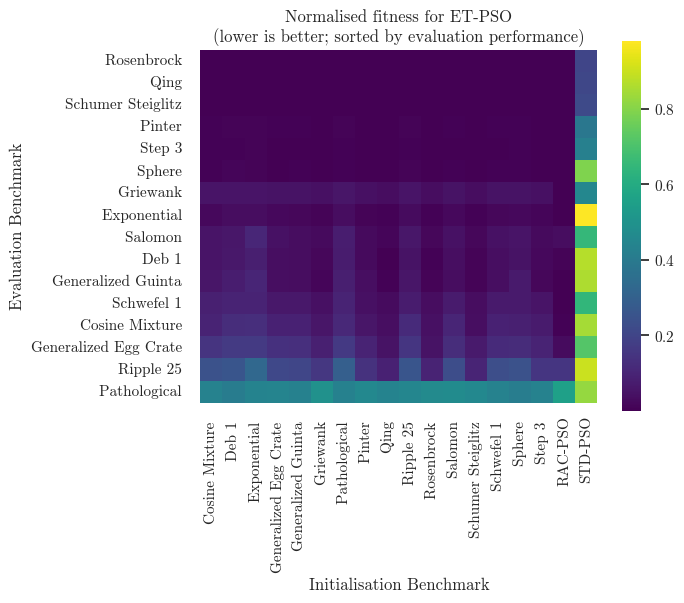

In [57]:
# groups and aggregates data from a DataFrame, calculates some statistics, and sorts it.
stats = (
    df_et[df_et.iter_num == 3900].groupby(['init_bm', 'eval_bm'])['scaled_gbest_fit']
        .agg(['mean', 'std', 'count'])
        .reset_index()
        .sort_values(['init_bm', 'eval_bm'])
)
s = stats.pivot(
    columns='init_bm',
    index='eval_bm',
    values='mean'
)
order = s.mean(axis=1).sort_values().index
s = s.reindex(order)
s = s[sorted(s.columns)]

fig, ax = plt.subplots()
# creates a heatmap from a DataFrame, using the mean values of the statistics calculated on it
sns.heatmap(
    s,
    square=True,
    ax=ax,
    cmap='viridis',
#     vmin=0,
#     vmax=1,
)

def fmt_labels(l):
    return l.replace('Function', '').replace('-', ' ').replace('rac pso', 'RAC-PSO').replace('std pso', 'STD-PSO')

ax.set_title('Normalised fitness for ET-PSO\n(lower is better; sorted by evaluation performance)')
ax.set_xlabel('Initialisation Benchmark')
ax.set_ylabel('Evaluation Benchmark')
ax.set_xticklabels([fmt_labels(l.get_text()) for l in ax.get_xticklabels()])
ax.set_yticklabels([fmt_labels(l.get_text()) for l in ax.get_yticklabels()])
plt.savefig('../report/imgs/fitness_per_et_pso.pdf', bbox_inches='tight')
plt.show()


In [58]:
best_non_rac = (
    stats[stats.init_bm != 'rac-pso']
    .groupby('eval_bm')[['init_bm', 'mean']]
    .apply(lambda gb: gb.sort_values('mean').head(1))
    .reset_index()
    .drop(columns=['level_1', 'mean'])
)
best_non_rac

,eval_bm,init_bm
0,Cosine Mixture Function,Qing Function
1,Deb 1 Function,Qing Function
2,Exponential Function,Qing Function
3,Generalized Egg Crate Function,Rosenbrock Function
4,Generalized Guinta Function,Qing Function
5,Griewank Function,Qing Function
6,Pathological Function,Deb 1 Function
7,Pinter Function,Rosenbrock Function
8,Qing Function,Rosenbrock Function
9,Ripple 25 Function,Qing Function


# Statistical comparison of performance

In [59]:
def compare(df, fname, init_eq_eval=False):
    nrows, ncols = (6, 3)
    fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    i = 0

    for i in range(max(len(axs.flatten()), len(df['eval_bm'].unique()))):
        ax = axs.flatten()[i]
        if i >= len(df['eval_bm'].unique()):
            ax.axis('off')
            continue
        eval_bm = df['eval_bm'].unique()[i]
        if init_eq_eval:
            init_bm = eval_bm
        else:
            init_bm = best_non_rac[best_non_rac['eval_bm'] == eval_bm]['init_bm'].values[0]
        print(f"eval: {eval_bm}, best_init: {init_bm}")
        sns.lineplot(
            data=df[(df['eval_bm'] == eval_bm) & df['init_bm'].isin(['std-pso', 'rac-pso', init_bm])],
            x='iter_num',
            y='scaled_gbest_fit',
            hue='init_bm',
            ax=ax,
            legend=False,
        )
        eva = eval_bm.replace(' Function', '')
        ini = init_bm.replace(' Function', '')
        ax.set(
            title=f"Evaluation: {eva}\nInitialisation: {ini}",
            xlabel="Iteration",
            ylabel="Scaled Fitness",
        )
        if i % ncols != 0:
            ax.set_ylabel(None)

        ax.set_yscale('log')

    #     if i >= 3:
    #         break
    plt.tight_layout()
    plt.savefig(fname)
# compare(df_et, '../report/imgs/iterations_logged.pdf')
# compare(df_et, '../report/imgs/iterations_logged_eq_eval.pdf', init_eq_eval=True)

In [145]:
tmp = (
    stats
    .groupby('eval_bm')[['init_bm', 'mean']]
    .apply(lambda gb: gb.sort_values('mean'))
    .reset_index()
    .drop(columns='level_1')
)
diff = (
    tmp[
        (tmp.init_bm == tmp.eval_bm) | 
        (tmp.init_bm == 'rac-pso')
    ]
    .sort_values(['eval_bm', 'init_bm'])
)
diff['kind'] = np.where(diff['init_bm'] == 'rac-pso', 'rac-pso', 'et-pso')
pivoted = diff.pivot(index='eval_bm', columns='kind', values='mean')

pivoted['quot'] = pivoted['rac-pso'] / pivoted['et-pso']
# pivoted
data = pd.DataFrame([pivoted['quot'], means]).T
data.columns = ['fitness_quot', 'mean_fitness']

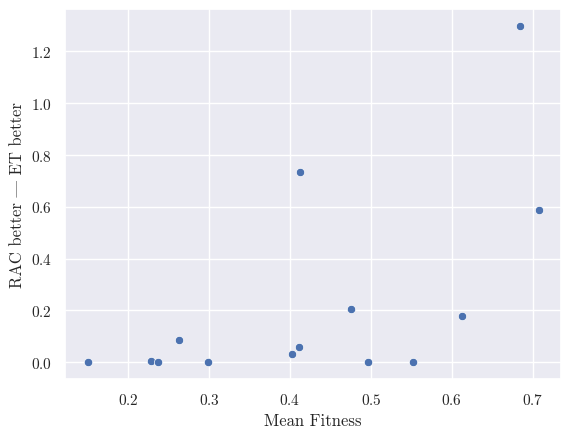

In [151]:
sns.scatterplot(
    data=data.reset_index(),
    y='fitness_quot', 
    x='mean_fitness',
#     hue='index',
#     legend='brief'
)
plt.ylabel('RAC better | ET better')
plt.xlabel('Mean Fitness')
# plt.yscale('log')
plt.show()